In [106]:
# camera calibration
from os import listdir
from scipy import misc
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


CAM_CAL_PATH = './camera_cal/'

cam_cal_imgs = []
for img_file in listdir(CAM_CAL_PATH):
    try:
        img = misc.imread(CAM_CAL_PATH + img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cam_cal_imgs.append(img)
    except IOError: pass

17 found.


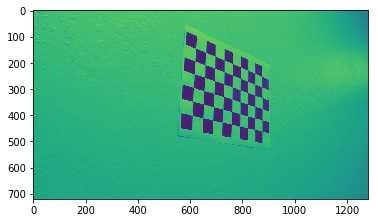

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

object_points = []
img_points = []
for img in cam_cal_imgs:
    plt.imshow(img)
    ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    if (ret):
        object_points.append(objp)
        img_points.append(corners)

print (len(img_points), 'found.')

In [3]:
img_size = (cam_cal_imgs[1].shape[1], cam_cal_imgs[1].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, img_points, img_size,None,None)

In [4]:
print (mtx, dist)

[[ 143.08147127    0.          639.4956478 ]
 [   0.          817.84727475  359.49932344]
 [   0.            0.            1.        ]] [[ -1.08929527e-02   3.00019798e-05  -4.85444918e-05   1.57584130e-03
   -2.35174525e-08]]


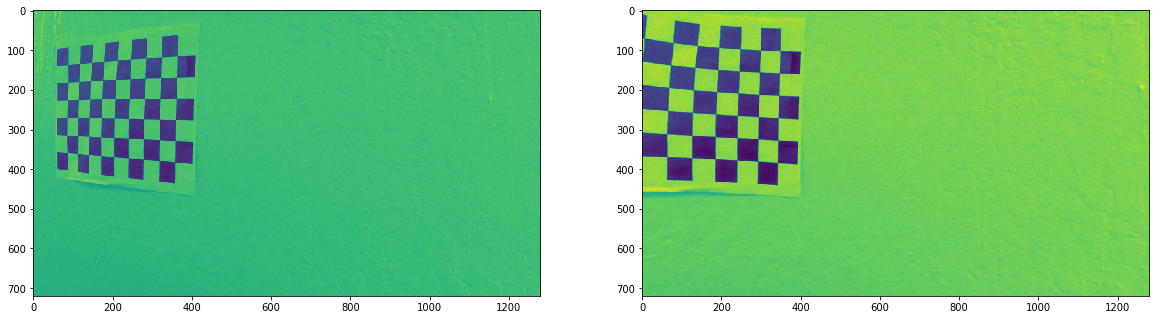

In [5]:
undist_test = cv2.undistort(cam_cal_imgs[10], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cam_cal_imgs[10])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [6]:
# loading the test images
TEST_PATH = './test_images/'

test_img = []
for img_file in listdir(TEST_PATH):
    try:
        img = misc.imread(TEST_PATH + img_file)
        test_img.append(img)
    except IOError: pass



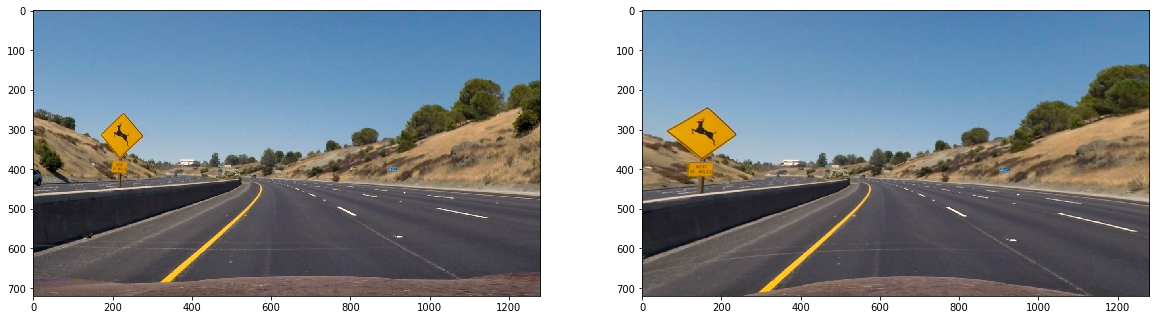

In [97]:
n = 3
undist_test = cv2.undistort(test_img[n], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test_img[n])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [123]:
# the pipeline magic
###############

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
    

def gradient_transform_x(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)    
    sobelx = np.absolute(sobelx / np.max(sobelx) * 255)
    grads = np.zeros(img.shape)
    grads[(sobelx > thresh[0]) & (sobelx < thresh[1])] = 1
    return grads

def gradient_transform_y(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)    
    sobely = np.absolute(sobely / np.max(sobely) * 255)
    grads = np.zeros(img.shape)
    grads[(sobely > thresh[0]) & (sobely < thresh[1])] = 1
    return grads

def gradient_transform_direction(image, ksize=5, thresh=(0 , 3.14)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    grad_direction = np.arctan2(sobely, sobelx)
    grad_direction = np.absolute(grad_direction)
    
    grads = np.zeros(grad_direction.shape)
    grads[(grad_direction > thresh[0]) & (grad_direction < thresh[1])] = 1
    return grads

def warp(img, M):
    size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)


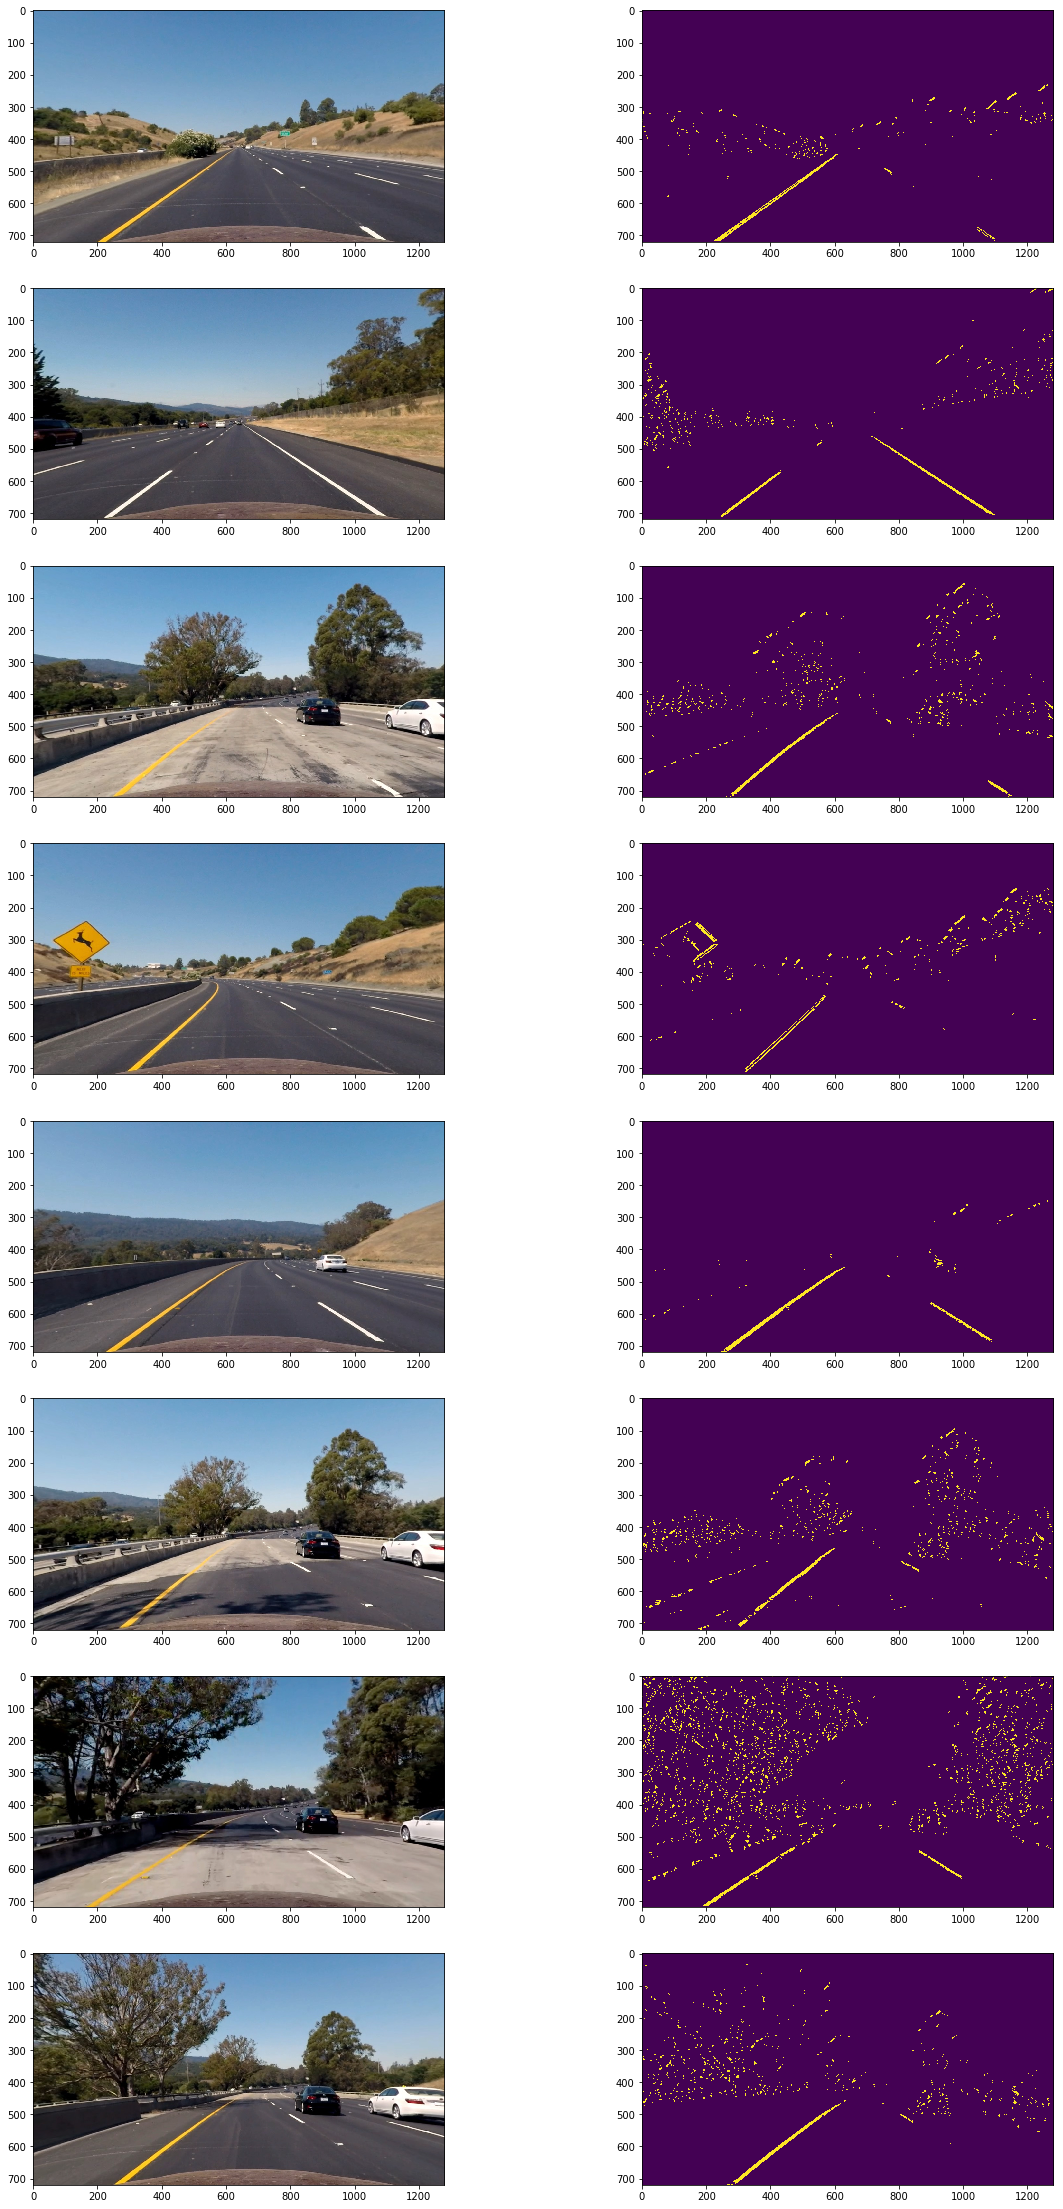

In [111]:
def gradient_transform_wrapper(image):
    img = np.copy(image)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img = img[:,:,2]
    
    gx = gradient_transform_x(img, ksize = 25, thresh=(40, 150))
    gy = gradient_transform_y(img, ksize = 25, thresh=(40, 150))
    gd = gradient_transform_direction(img, ksize=25, thresh=(2,2.5))

    combo = np.zeros(gd.shape)

    combo[((gy == 1 ) | (gx ==1)) & (gd ==1)] = 1
    
    return combo
    """
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.imshow(gx)
    plt.subplot(2,2,2)
    plt.imshow(gy)
    plt.subplot(2,2,3)
    plt.imshow(gd)
    plt.subplot(2,2,4)
    plt.imshow(combo)
    """
    
plt.figure(figsize=(20,40))
l = len(test_img)
for i, image in enumerate(test_img):
    img = undistort(image)
    plt.subplot(l, 2, i * 2 + 1)
    plt.imshow(img)
    plt.subplot(l, 2, i * 2 + 2)
    plt.imshow(gradient_transform_wrapper(img))
    
    

In [129]:
misc.imsave('calib.png', undistort(test_img[0]))


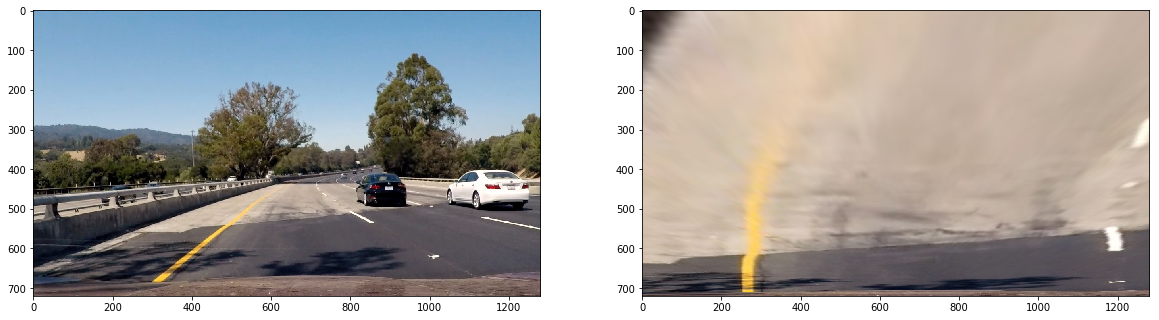

In [139]:
src = np.float32([[205, 720]
                 ,[535, 490]
                 ,[750, 490]
                 ,[1101, 720]])

dst = np.float32([[205, 720]
                 ,[205, 490]
                 ,[1101, 490]
                 ,[1101, 720]])

M = cv2.getPerspectiveTransform(src, dst)

warped = warp(test_img[5], M)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test_img[5])
plt.subplot(1,2,2)
plt.imshow(warped)

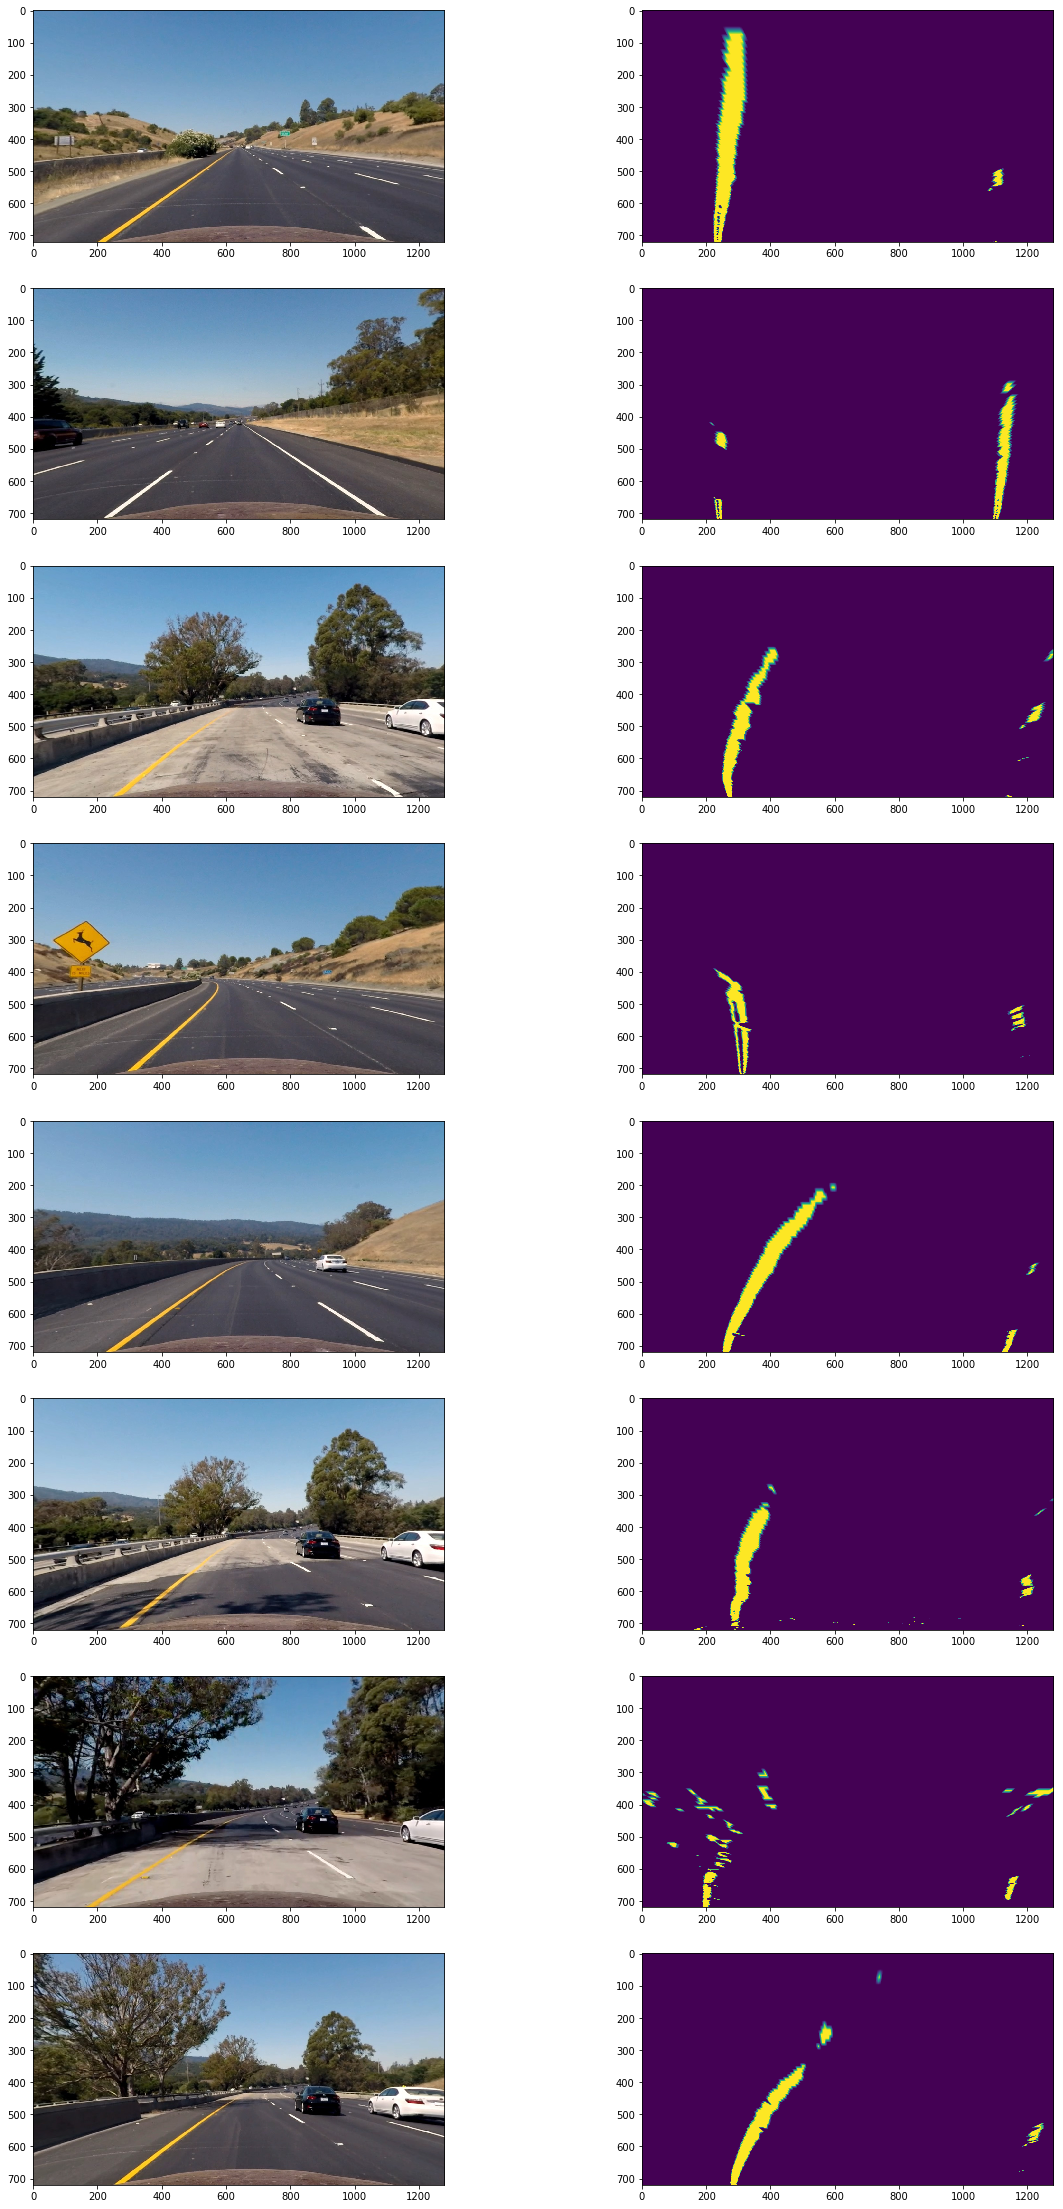

In [138]:
def birds_eye(image, M):
    img = np.copy(image)
    img = undistort(img)
    img = gradient_transform_wrapper(img)
    img = warp(img, M)
    return img


plt.figure(figsize=(20,40))
l = len(test_img)
for i, image in enumerate(test_img):
    img = undistort(image)
    plt.subplot(l, 2, i * 2 + 1)
    plt.imshow(img)
    plt.subplot(l, 2, i * 2 + 2)
    plt.imshow(birds_eye(img, M))
    
